In [59]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import time

from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Load the dataset
file_path = '/content/drive/My Drive/Colab Notebooks/creditcard.csv'
df = pd.read_csv(file_path)

In [61]:
# Data Preprocessing
# Scale the 'Amount' and 'Time' features
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

# Split the data into features and target
X = df.drop(columns=['Class'])
y = df['Class']


In [62]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Balance the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [63]:
# Define models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(n_estimators=10, max_depth=3, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    "Adaboost": AdaBoostClassifier(n_estimators=10, algorithm="SAMME", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=7, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=10, max_depth=3, random_state=42),
}


In [64]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=[
    "Classifier Name", "Training or Test Set", "Balanced or Unbalanced Train Set",
    "Number of Training Samples", "Number of Fraud Samples",
    "True Positives (TP)", "True Negatives (TN)", "False Positives (FP)", "False Negatives (FN)",
    "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC",
    "Training Time (s)", "Prediction Time (s)"  # New columns
])
results_df['Training Time (s)'] = np.nan  # Initialize new columns with NaN
results_df['Prediction Time (s)'] = np.nan

In [65]:
# Define evaluation function
def evaluate_model(name, model, X_train, X_test, y_train, y_test, balanced="Unbalanced"):
    # Train the model
    start_time = time.time()  # Record start time before training
    model.fit(X_train, y_train)
    training_time = time.time() - start_time  # Calculate training time

    # Initialize metrics storage for both train and test sets
    for X, y, set_type in [(X_train, y_train, "Train"), (X_test, y_test, "Test")]:
        # Predictions and probabilities
        start_time = time.time() # Record start time before prediction
        y_pred = model.predict(X)
        prediction_time = time.time() - start_time # Calculate prediction time (for test set)
        y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None

        # Confusion Matrix
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Performance Metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        roc_auc = roc_auc_score(y, y_prob) if y_prob is not None else None

        cm = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
        disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if desired
        plt.title(f"Confusion Matrix - {name} ({balanced}) - {set_type} Set")
        plt.show()

        # Append results to DataFrame
        results_df.loc[len(results_df)] = [
            name, set_type, balanced, len(y), y.sum(), tp, tn, fp, fn,
            round(accuracy, 2), round(precision, 2), round(recall, 2),
            round(f1, 2), round(roc_auc, 2) if roc_auc else "N/A",
            round(training_time, 2) if set_type == "Test" else np.nan,  # Add training time for Test set
            round(prediction_time, 2) if set_type == "Test" else np.nan   # Add prediction time for Test set
        ]
    # # Add runtime information to results_df (outside the loop)
    # results_df.loc[(results_df['Classifier Name'] == name) & (results_df['Training or Test Set'] == 'Test'), 'Training Time (s)'] = round(training_time, 2)
    # results_df.loc[(results_df['Classifier Name'] == name) & (results_df['Training or Test Set'] == 'Test'), 'Prediction Time (s)'] = round(prediction_time, 2)

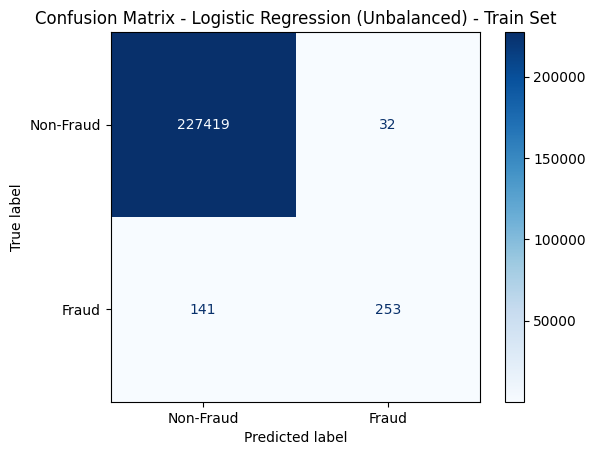

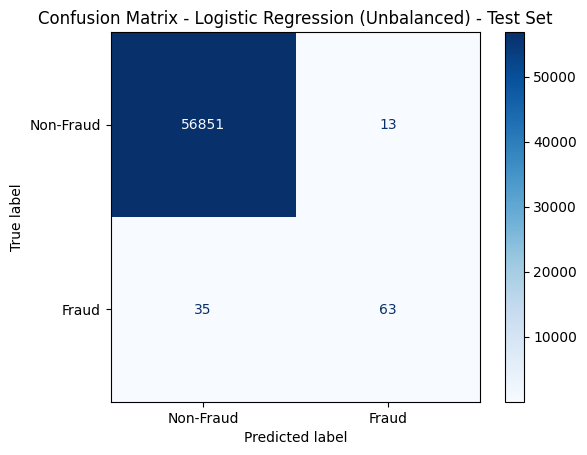

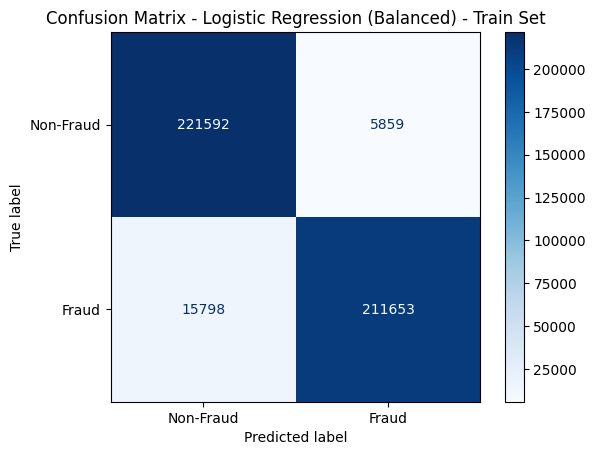

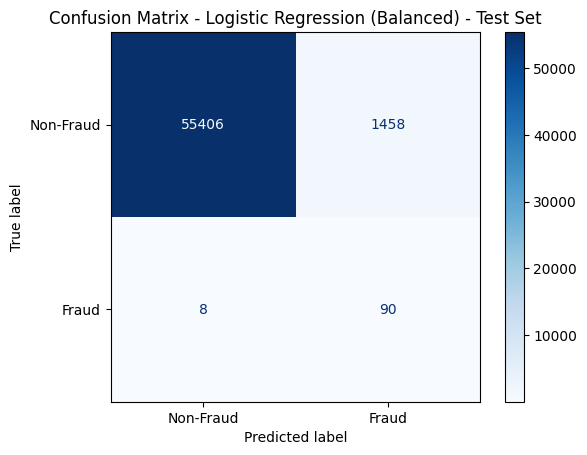

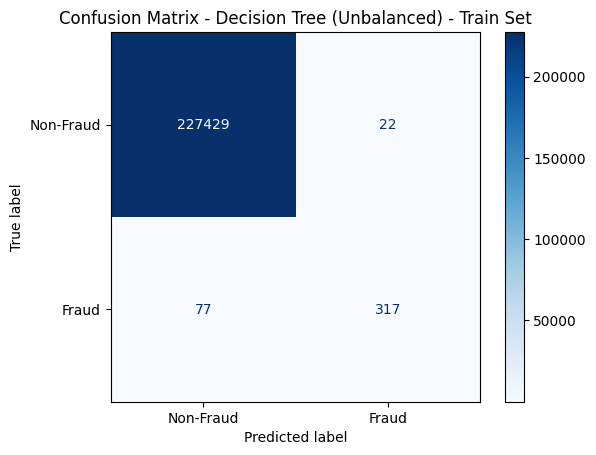

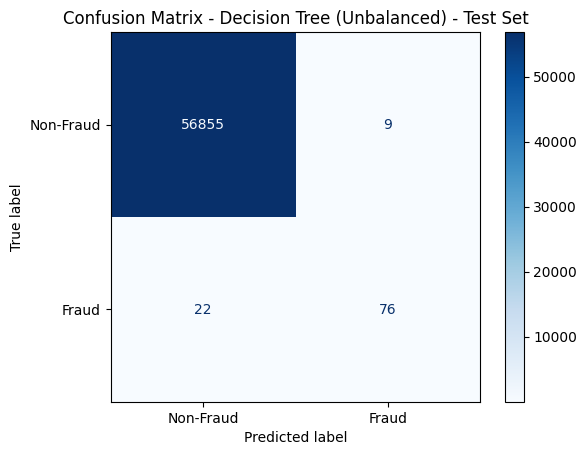

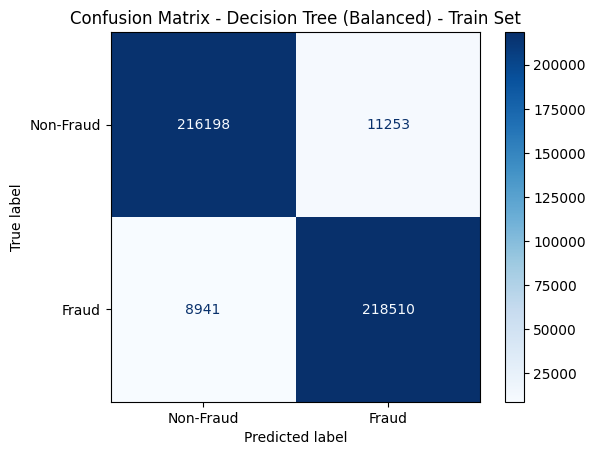

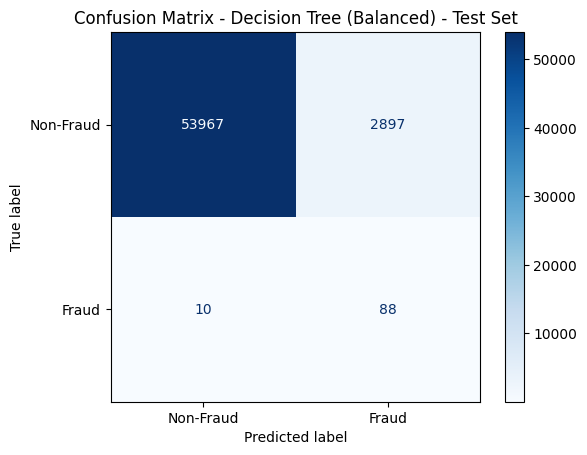

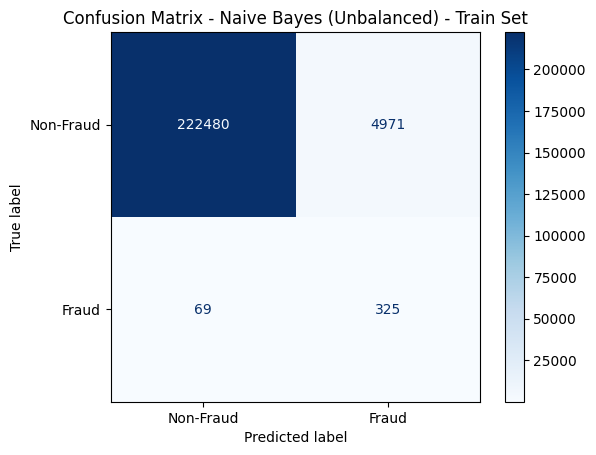

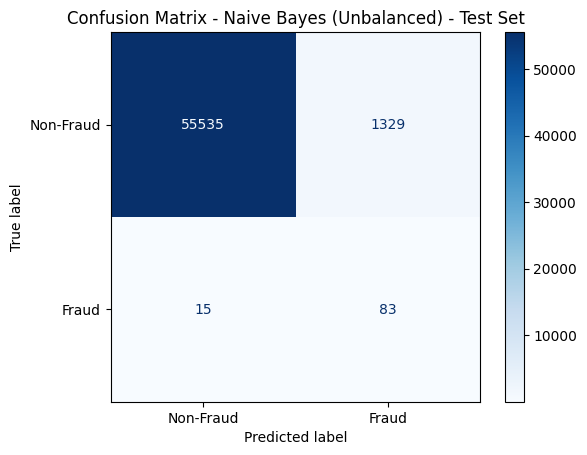

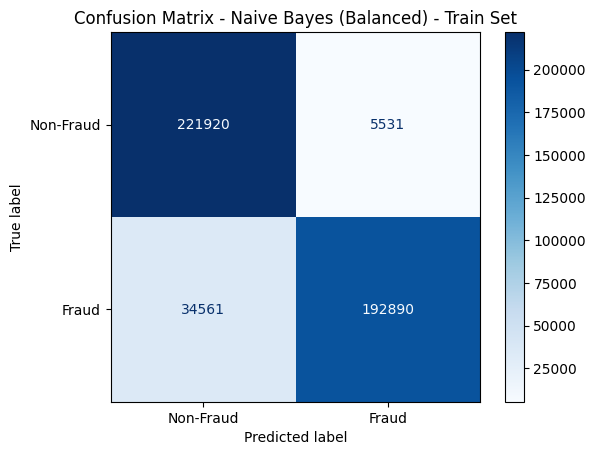

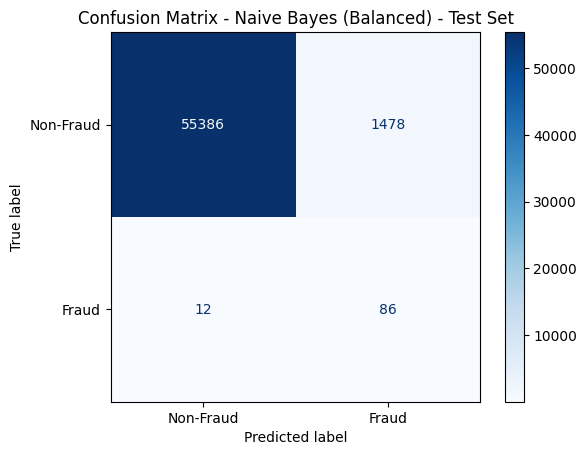

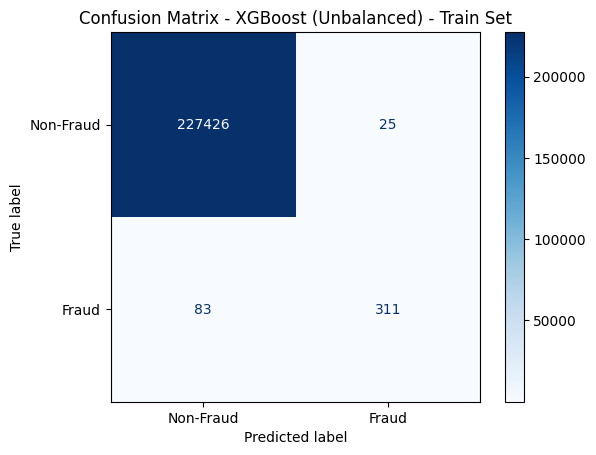

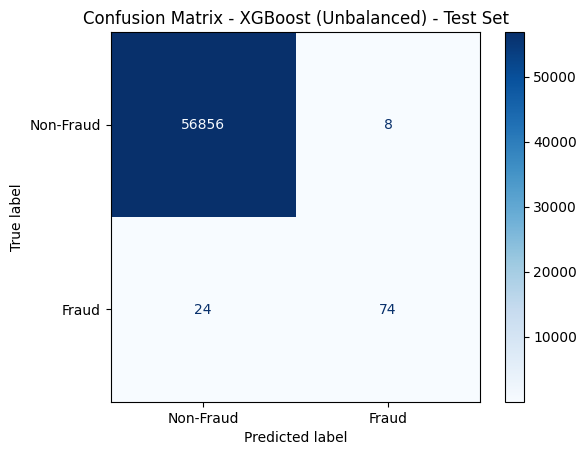

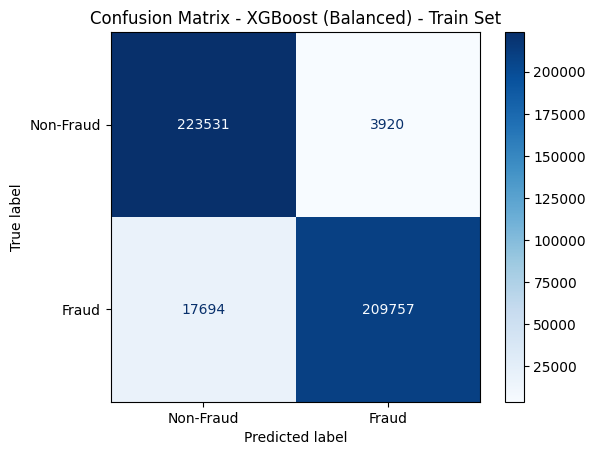

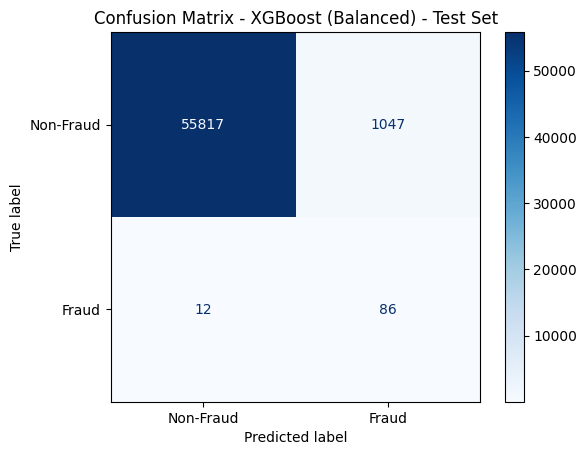

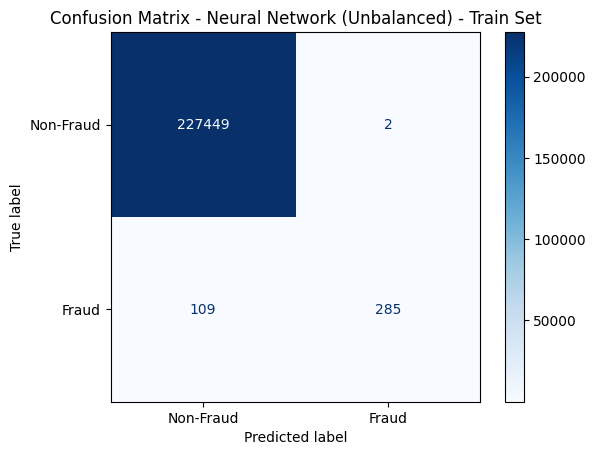

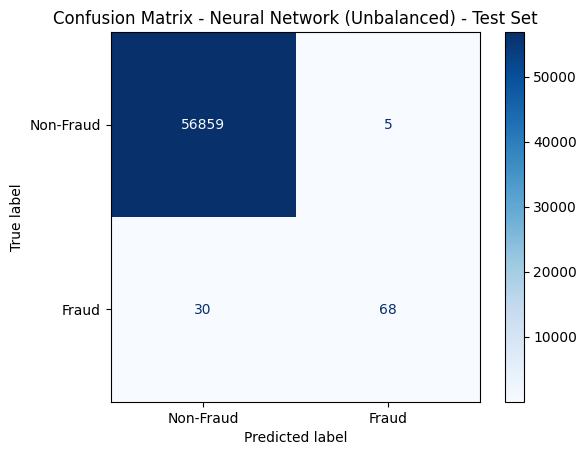

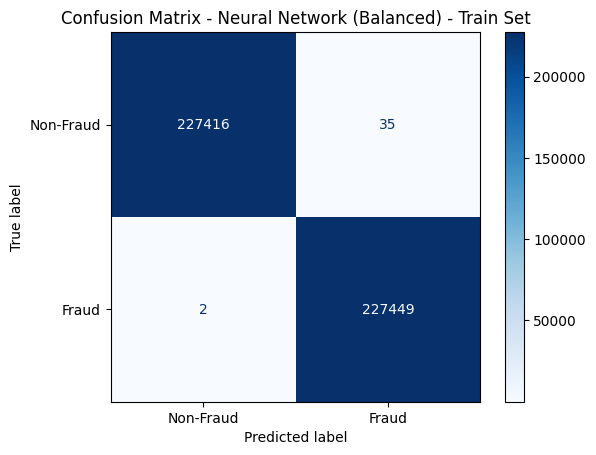

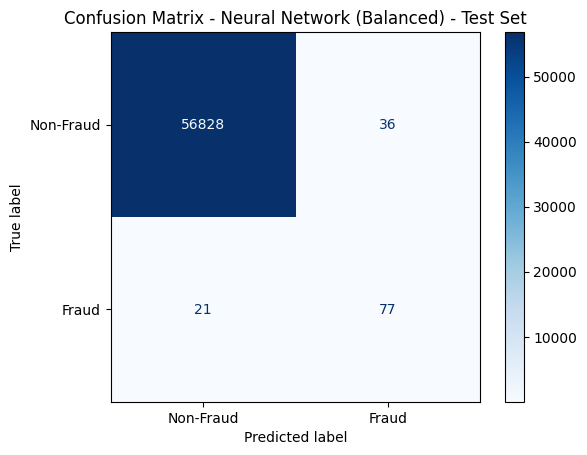

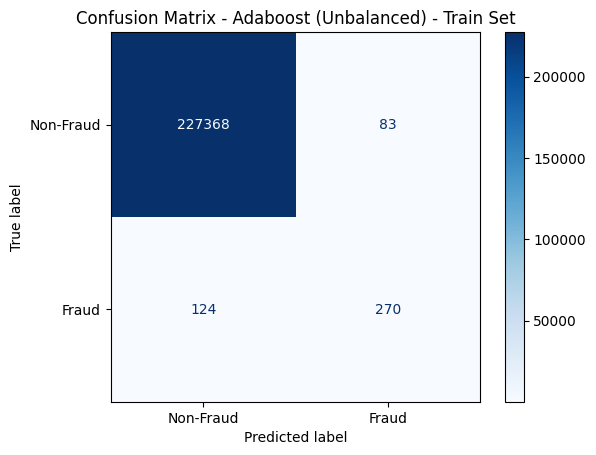

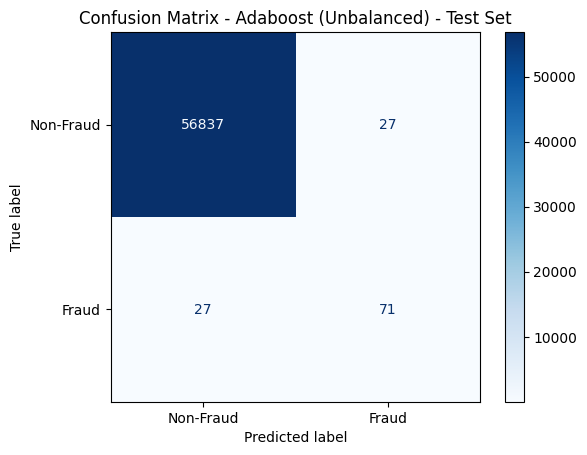

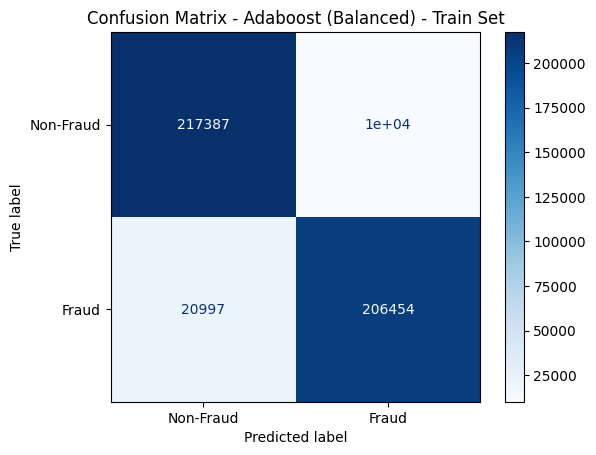

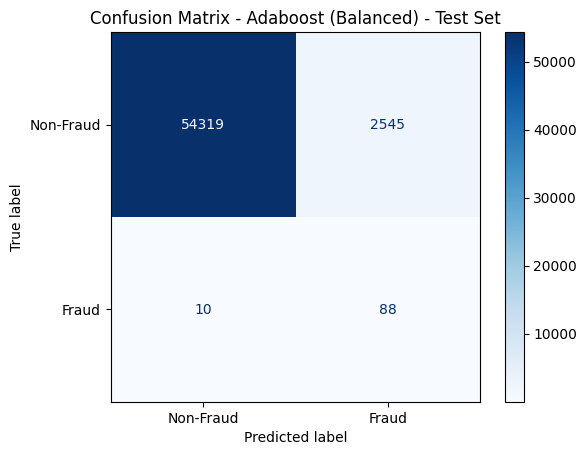

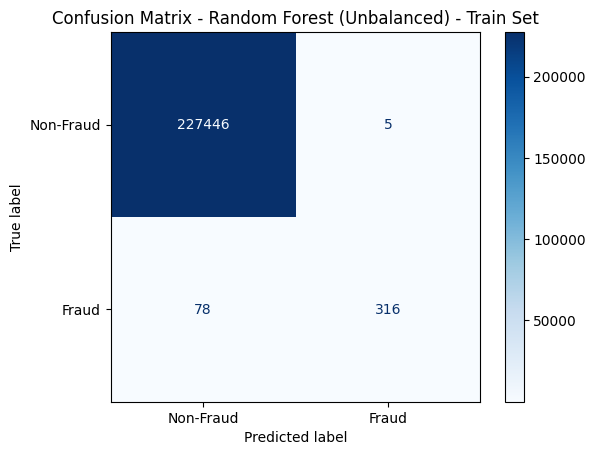

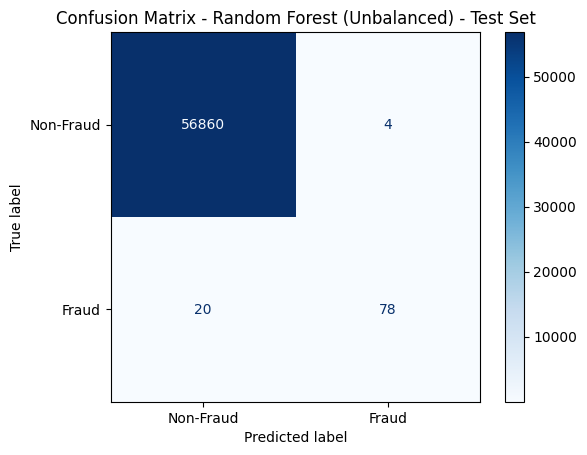

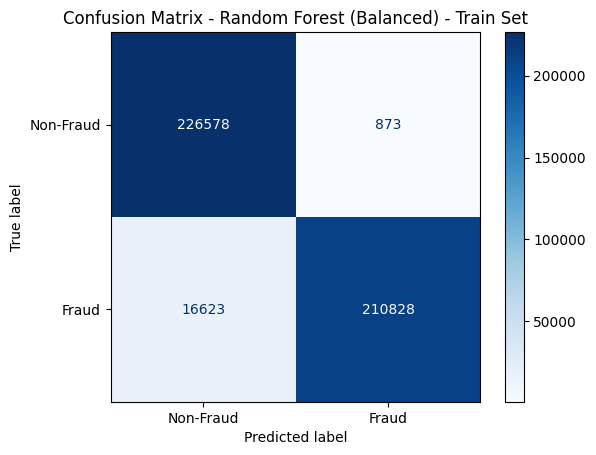

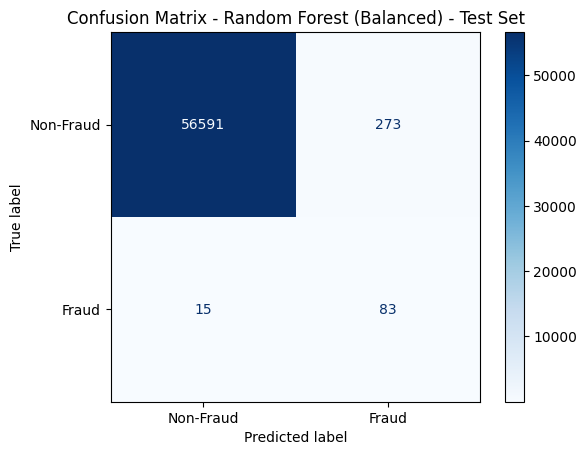

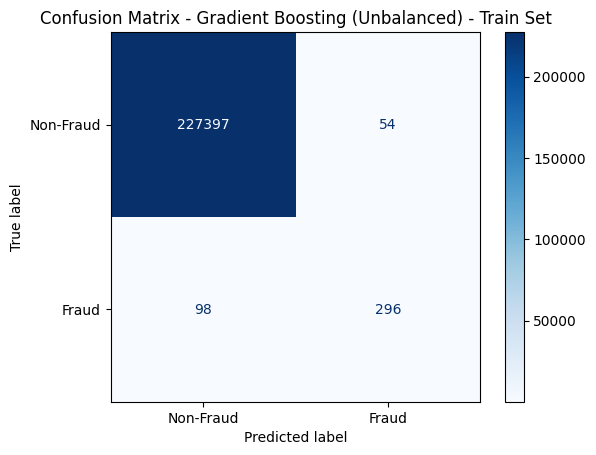

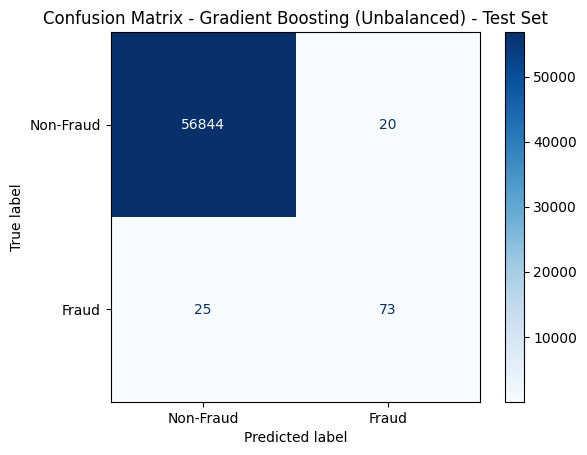

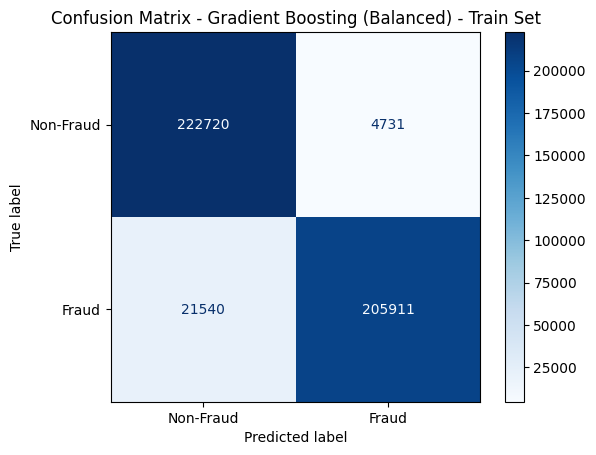

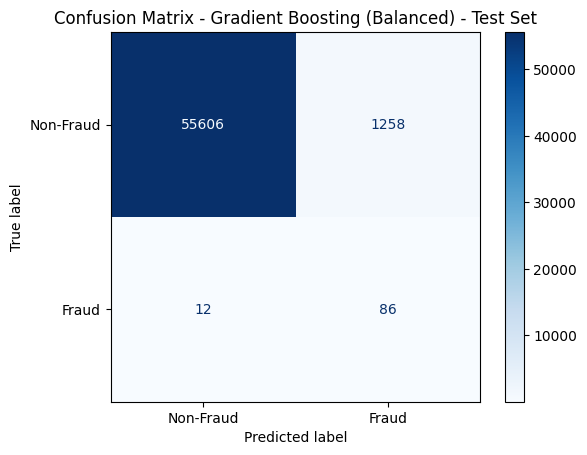

In [66]:
# Evaluate each model on unbalanced and balanced training sets
for model_name, model in models.items():
    # Unbalanced training set
    evaluate_model(model_name, model, X_train, X_test, y_train, y_test, balanced="Unbalanced")

    # Balanced training set
    evaluate_model(model_name, model, X_train_balanced, X_test, y_train_balanced, y_test, balanced="Balanced")



In [67]:
# Save the results to a CSV file
results_df.to_csv("balancedDataOutcomes.csv", index=False)
print("Results saved to balancedDataOutcomes.csv")

Results saved to balancedDataOutcomes.csv
